<a href="https://colab.research.google.com/github/MichalZienkowicz/rozpoznawanie-cyfr-audio-python-gmm/blob/main/Projekt_Klasyfikator_Liczb_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJEKT - ROZPOZNAWANIE CYFR PRZY UŻYCIU MODELI GMM



## 1. Opis projektu/schemat



Celem projektu jest stworzenie skryptu, który będzie mógł zwrócić informację, jaka cyfra została wypowiedziana na zadanym mu nagraniu. Aby to osiągnąć, wykorzystane zostaną metody MFCC oraz GMM. Wyniki na zbiorze ewaluacyjnym są zapisywane w formie pliku csv.

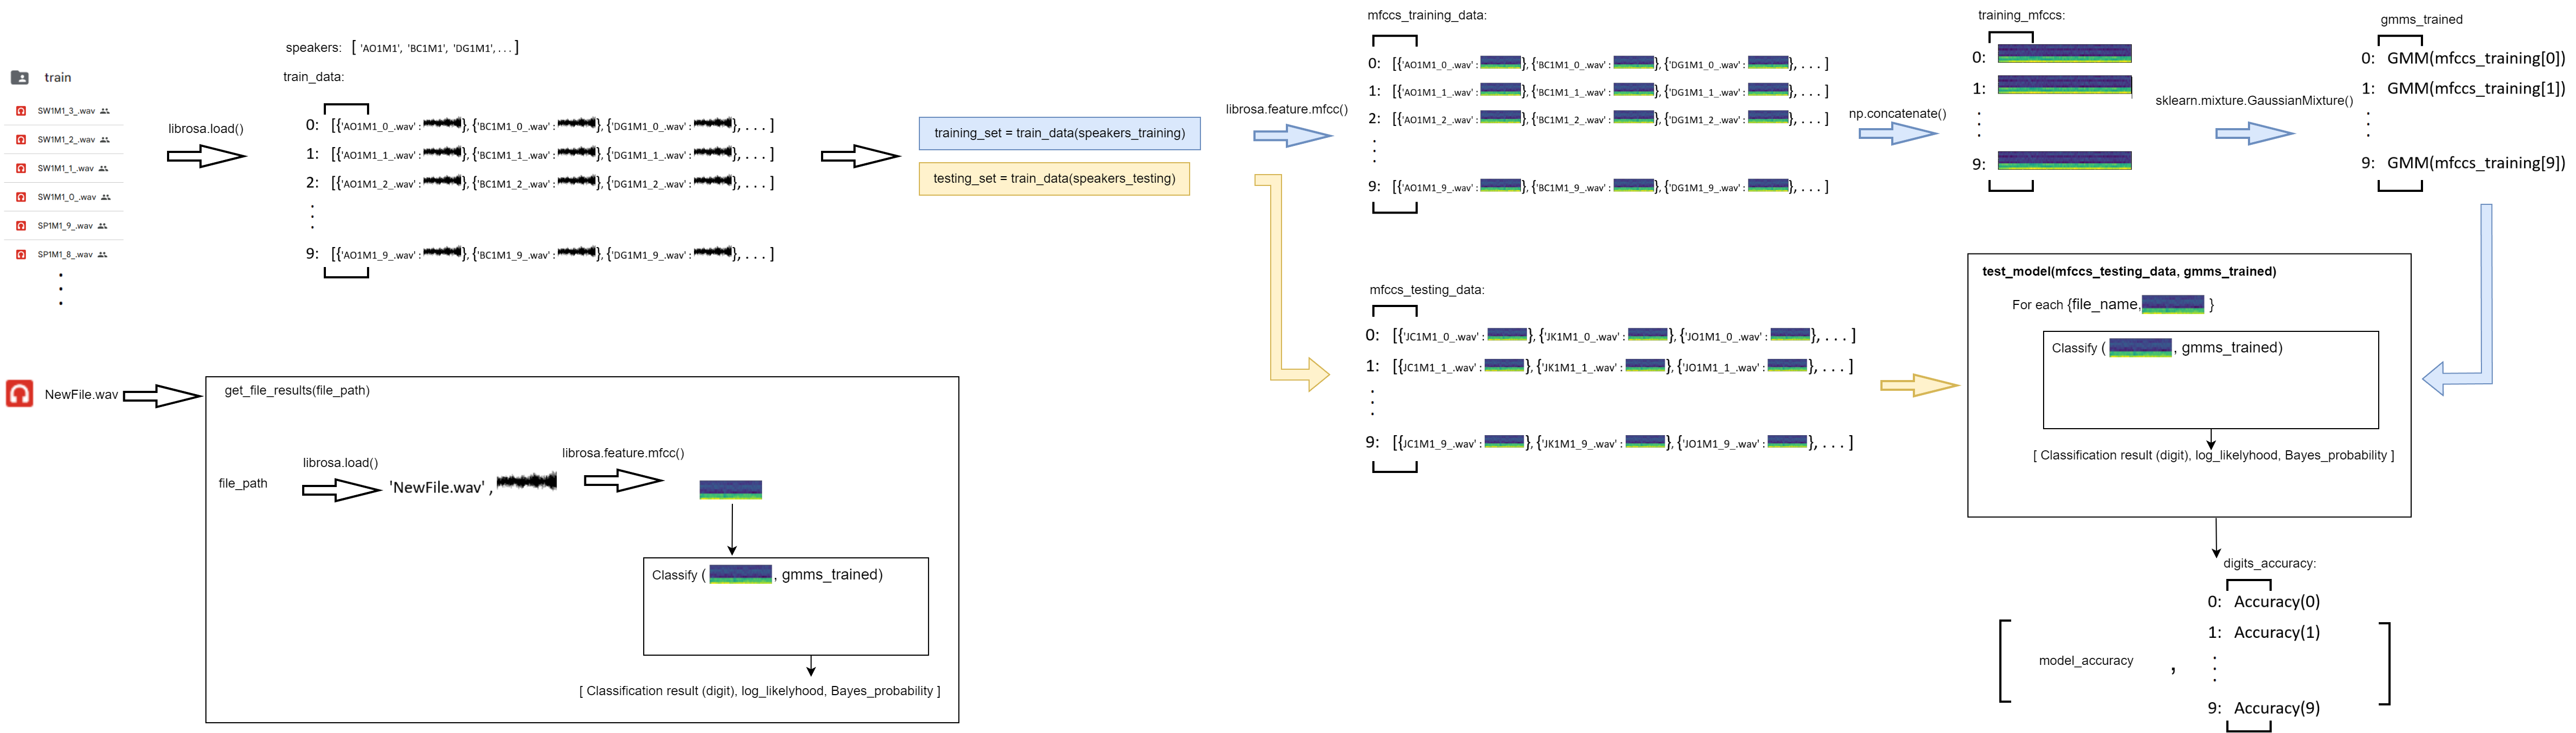

Opis funkcji:
- `select_data_by_speakers()`: przyjmuje listę słowników z załadowanymi danymi oraz listę mówców. Tworzy i zwraca listę słowników stanowiącą część załadowanych danych odpowiadającą przyjętym mówcom.
  - uzasadnienie: pozwala na proste i wygodne stworzenie zbioru testowego i treningowego w zależności od porządanych mówców w zbiorach.
- `create_librosa_mfcc()`: funkcja przyjmuje sygnał audio oraz opcjonalne parametry, na podstawie których tworzy macierz mfcc z użyciem librosa.feaature.mfcc().
  - uzasadnienie: pozwala w spójny sposób tworzyć mfcc w całym programie, uniknąć przyjęcia różnych parametrów do mfcc w różnych miejscach kodu.
- `create_mfccs_dictlist()` : funkcja przyjmuje listę słowników w formacie     [ {'ID' : ndarray(wektro sygnału)} ] i zwraca słownik w formacie [ {'ID' : ndarray(macierz MFCC)} ]. MFCC otrzymane z `create_librosa_mfcc()`.
- `create_concatenated_mfccs()` : funkcja przyjmuje listę słowników w formacie [ {'ID' : ndarray(macierz MFCC)}, ... ] i tworzy listę złączonych ze wszystkich mfcc dla odpowiedniej cyfry [ ndarray(MFCC), ... ].
  - uzasadnienie: służy to przygotowaniu do treningu modeli gmm.
- `train_gmms()`: funkcja przyjmuje listę treningowych macierzy mfcc, liczbę komponentów oraz typ macierzy kowariancji i zwraca listę wytrenowanych na danych mfcc modeli dla każdej cyfry.
- `classify()`: funkcja przyjmuje macierz mfcc dla pojedynczego pliku oraz listę z wytrenowanymi modelami gmm dla każdej z liczb, zwraca jaka liczba została rozpoznana (sprawdza to po indeksie maksimum loglikelyhood), loglikelyhood i prawdopodobieństwo Bayesa.
  - uzasadnienie: funkcję tę można wykorzystać w testowaniu danych i wyznaczaniu dokładności (accuracy) działania skryptu
- `test_model()`: funkcja przyjmuje listę słowników z mfcc zbioru testowego oraz listę wytrenowanych modeli gmm. następnie wykonuje klasyfikację każdego z plików. Zwraca informacje jaki procent plików został rozpoznany poprawnie ogólnie oraz procent poprawnie rozpoznanych dla każdej cyfry z osobna.
  - uzasadnienie: pozwala ocenić skuteczność modelu oraz zobaczyć z jakimi cyframi model radzi sobie najlepiej, najgorzej.
- `get_file_results()`: funkcja przyjmuje ścieżkę do pliku, ka który wewnątrz funkcji zostaje transformowany na sygnał, z którego następnie liczone jest mfcc. Po uzyskaniu mfcc wykonywana jest klasyfikacja, której wartości wraz z informacją o częstotliwości próbkowania przyjętego pliku oraz jego potencjalnym resamplingu zostają zwracane.
  - uzasadnienie: funkcja umożliwia wygodne klasyfikowanie nowych plików konwertując je na dane spójne z danymi na których operuje model - przykładowo jednakowy rodzaj mfcc.

Struktury przechowywania danych zawierających:
- cechy wyekstrachowane z plików audio - lista słowników - umożliwia to łatwą identyfikację jaki plik jest używany
- modele cech - lista - ułatwia to rozpoznawanie zakwalifikowanej cyfry. W funkcji classify - sprawdza się to po indeksie



## 2. Podział zadań

Ola:
*   Wykonanie opisów teoretycznych - dbanie o estetykę części opisowej
*   Klasyfikacja zadanego MFCC:
  * stworzenie funkcji obliczającej loglikelyhood
  * zwrócenie najwyższego prawdopodobieństwa, w celu wypisania jaka liczba została rozpoznana - wykorzystanie klasyfikatora Bayesa
* Wykonanie pliku csv pokazującego dokładność działania modelu - wykorzystanie funkcji do testowania

Michał:
*   Wykonanie schematu projektu
*   Przygotowanie środowiska oraz danych:
  * załadowanie danych i podział na zbiory treningowe i testowe
  * przygotowanie odpowiednich metod na przechowywanie danych (słowniki/listy)
  * stworzenie funkcji konwertującej pliki, aby mogły przejść klasyfikację
*   Wykonanie testowania danych:
  * klasyfkowanie plików ze zbioru testowego - zwrócenie struktury wskazującej jak zostały zaklasyfikowane testowe dane
  * otrzymanie dokładności działania modelu
* testy hiperparametrów:
  * CVMN
  * Liczba współczynników MFCC
  * Liczba filtrów melowych
  * Liczba komponentów GMM
  * Delty-delty

Mikołaj:
*   Dbanie o estetykę notebooka
*   Wykonanie funkcji tworzącej macierze MFCC:
  * zadbanie o możliwość zmiany parametrów wykonywania MFCC
  * połączenie wszystkich danych w odpowiednie struktury
*   Stworzenie modeli do rozpoznawania liczb jako zmienne:
  * zadbanie o możliwość zmiany parametrów GMM
  * otrzymanie wytrenowanych modeli dla poszczególnych cyfr
*testy hiperparametrów:
  * Filtry melowe
  * Liczba kompontenów GMM
  * Macierz kowariancji

Wszyscy:
*   Praca nad planem działania
*   Obmyślenie potrzebnych funkcji


# Przygotowanie środowiska

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os
root = '/content/gdrive/MyDrive/colab/tm2023/Grupa_4/Projekt_Klasyfikator_Liczb/'
os.chdir(root)
!ls
%ls


import librosa
import numpy as np
from sklearn import mixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from copy import deepcopy
import matplotlib.pyplot as plt
import csv

parameters_mfcc = {
    'sr' : 16000,
    'n_mfcc' : 10,
    'n_fft' : 512,
    'win_length' : 320,
    'hop_length' : 160,
    'n_mels' : 30
}

parameters_gmm = {
    'n_components' : 5,
    'covariance_type' : 'diag',
    'init_params' : 'kmeans',
    'random_state' : 12
}

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
 digits   'Kopia Projekt_Klasyfikator_Liczb'   __pycache__      tescik.wav
 eval	   Kopia_tescik.wav		       results.csv      tmProjekt.txt
 eval_ia   Projekt_Klasyfikator_Liczb.ipynb    results_ia.csv
 eval.py   projekt-plan.gdoc		       schemat.png
 digits/   'Kopia Projekt_Klasyfikator_Liczb'   __pycache__/     tescik.wav
 eval/      Kopia_tescik.wav                    results.csv      tmProjekt.txt
 eval_ia/   Projekt_Klasyfikator_Liczb.ipynb    results_ia.csv
 eval.py    projekt-plan.gdoc                   schemat.png


# Parametryzacja zbioru audio

## Załadowanie wszystkich plików

In [ ]:
folder_path = 'digits/train'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.wav')] #names of all the .wav files in the folder
file_names.sort()

speakers = []
train_data = [{} for _ in range(10)]
for file_name in file_names:
  file_path = os.path.join(folder_path, file_name)  #creates paths to files
  audio_data, _ = librosa.load(file_path, sr=None)

  speaker_id = file_name[0:5]
  if speaker_id not in speakers:
    speakers.append(speaker_id)

  digit = int(file_name[6])
  train_data[digit].update({file_name : audio_data})

## Stworzenie zbioru testowego i treningowego

In [ ]:
def select_data_by_speakers(data, speakers):
  selected_list = []

  for digit_dict in data:
    selected_dict = {key: value for key, value in digit_dict.items() if key[0:5] in speakers} #selects kvp of given speakers from dictionary
    selected_list.append(selected_dict)
  return selected_list

speakers_training = speakers
speakers_testing = speakers[0:5]

training_set = select_data_by_speakers(train_data, speakers_training)
testing_set = select_data_by_speakers(train_data, speakers_testing)

## Stworzenie macierzy MFCC poszczególnych zbiorów

In [ ]:
#librosa mfcc calculation
def create_librosa_mfcc(signal, param_dict):

  mfcc = librosa.feature.mfcc(y=signal, sr=param_dict['sr'], n_mfcc=param_dict['n_mfcc'], n_fft=param_dict['n_fft'],
                                        win_length=param_dict['win_length'], hop_length=param_dict['hop_length'], n_mels=param_dict['n_mels'])
  return mfcc

#creates list of dictionaries with each signal vector's MFFC matrix assined to each ID.
def create_mfccs_dictlist(signal_dictlist, param_dict):

  result = [{} for _ in range(10)]

  for i in range(0,len(signal_dictlist)):

    for j in range(0, len(signal_dictlist[i])):

      single_signal = list(signal_dictlist[i].values())[j]
      key = list(signal_dictlist[i])[j]
      single_mfcc = create_librosa_mfcc(single_signal,param_dict).T
      result[i][key] = single_mfcc

  return result

#takes list of dictionaries [10 x {ID : MFCC, ...}] and creates list of 10
#concatenated MFCCs matrices.
def create_concatenated_mfccs(mfcc_dictlist):

  result = []

  for i in range(0,len(mfcc_dictlist)):

    to_concatenate = []

    for j in range(0, len(mfcc_dictlist[i])):

      single_mfcc = list(mfcc_dictlist[i].values())[j]
      to_concatenate.append(single_mfcc)

    mfcc_concatenated = np.concatenate(to_concatenate)
    result.append(mfcc_concatenated)
  return result

#zrobiono pokazowo dla zbioru treningowego
#lista słowników w formacie ID : macierz mfcc
mfccs_training_data = create_mfccs_dictlist(training_set,parameters_mfcc)
#lista macierzy mfcców dla cyfr od 0 do 9 trening
training_mfccs = create_concatenated_mfccs(mfccs_training_data)

#Trening klasyfikatora - Stworzenie modeli GMM

In [ ]:
##creates list of gmm models based on training data list
def train_gmms(mfccs, param_dict):

  gmms = []

  for mfcc in mfccs:
    gmm = mixture.GaussianMixture(n_components = param_dict['n_components'], covariance_type = param_dict['covariance_type'],
                                  tol=0.001, reg_covar=1e-02, max_iter=100,
                                  n_init=1, init_params=param_dict['init_params'], weights_init=None, means_init=None,
                                  precisions_init=None, random_state=param_dict['random_state'], warm_start=False,
                                  verbose=0, verbose_interval=1)
    gmm.fit(mfcc)
    gmms.append(gmm)
  return gmms

#macierz mfcców dla cyfr od 0 do 9 treningu
gmms_trained = train_gmms(training_mfccs, parameters_gmm)

# Klasyfikator

In [ ]:
def classify(mfcc_test, gmm_models):
  num_samples = len(mfcc_test)
  num_models = len(gmm_models)

  p_class = [1/10]*num_models #we assume the same probability of each number appearing
  loglike_data = [0]*num_models
  Bayes_data =  [0]*num_models
  Bayes_sum = 0

  for model_idx, model in enumerate(gmm_models):
    loglike_data[model_idx] = model.score(mfcc_test)

  for i in range(0,len(loglike_data)):
     Bayes_sum += p_class[i]*np.exp(loglike_data[i])

  for loglike in range(0,len(loglike_data)):
   Bayes_data[loglike] = np.exp(loglike_data[loglike])*p_class[loglike]/Bayes_sum

  max_loglike_value = np.max(loglike_data) # loglikelyhood value
  max_loglike_idx =  np.argmax(loglike_data) # classified as:

  max_Bayes_value = np.max(Bayes_data)  # Bayes probability value
  max_Bayes_idx =  np.argmax(Bayes_data) # classified as:
  #print(Bayes_data)
  #print(loglike_data)
  return max_loglike_idx, max_loglike_value, max_Bayes_value

# Test

In [ ]:
def test_model(mfccs_data, gmm_models):

  digits_accuracy = [0]*10
  for i,mfcc_dict in enumerate(mfccs_data): #iterates over dictionaries in list
    mfccs = mfcc_dict.values()              #extract mfccs from dictionaries

    for mfcc in mfccs:
      result,_,_ =  classify(mfcc, gmm_models) #result =  digit as a result of classification
      if result == i:
        digits_accuracy[i] += 1/len(mfccs)

  model_accuracy = sum(digits_accuracy)/10
  return model_accuracy,digits_accuracy


def test_model_sklearn(mfccs_data, gmm_models, normalisation=True):

  y_true = []
  y_pred = []

  for i, mfcc_dict in enumerate(mfccs_data):
    mfccs = mfcc_dict.values()

    for mfcc in mfccs:
      result,_,_ = classify(mfcc,gmm_models)
      y_pred.append(result)
      y_true.append(i)

  model_accuracy = accuracy_score(y_true, y_pred, normalize=normalisation)
  return model_accuracy


mfccs_testing_data = create_mfccs_dictlist(testing_set,parameters_mfcc)
acc,dig_acc = test_model(mfccs_testing_data, gmms_trained)
acc_sklearn = test_model_sklearn(mfccs_testing_data, gmms_trained)

print('accuracy: ', acc, '    accuracy sklearn: ', acc_sklearn)
for i  in range(10):
  print('accuracy for ',i,' = ', dig_acc[i])

accuracy:  0.9800000000000001     accuracy sklearn:  0.98
accuracy for  0  =  1.0
accuracy for  1  =  1.0
accuracy for  2  =  1.0
accuracy for  3  =  1.0
accuracy for  4  =  1.0
accuracy for  5  =  1.0
accuracy for  6  =  1.0
accuracy for  7  =  1.0
accuracy for  8  =  1.0
accuracy for  9  =  0.8


# Interface

In [ ]:
def get_file_results(file_path, gmm_models, param_dict, resample = True, target_fs = 16000):  #exctracts mfcc, and performs classification
  resampled = False
  audio_data, fs = librosa.load(file_path, sr=None)

  if fs != target_fs and resample:
    audio_data = librosa.resample(audio_data, orig_sr=fs, target_sr=target_fs)
    resampled = True

  mfcc = create_librosa_mfcc(audio_data,param_dict).T
  result, log_lh, bayes_prob = classify(mfcc, gmm_models)
  return result, log_lh, bayes_prob, fs, resampled


file_path = 'digits/train/SG2M1_9_.wav'
result, log_likelyhood, bayes_probability, fs, is_resampled = get_file_results(file_path, gmms_trained, parameters_mfcc)

print(f'File: {file_path} | classified as: {result} | log-likelyhood: {log_likelyhood:.2f} | probability: {bayes_probability:.2f} | Original s.r.: {fs} | resampled: {is_resampled}' )

File: digits/train/SG2M1_9_.wav | classified as: 9 | log-likelyhood: -38.49 | probability: 0.45 | Original s.r.: 16000 | resampled: False


# Cross walidacja i wyznaczanie Accuracy

In [ ]:
n_splits = 11
audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc) #create mfcc_dictlist of the entire data to later be splitted in cross_validate

def cross_validate(mfcc_data, gmm_param_dict, n_splits, speakers):

  kf = KFold(n_splits)
  kf.get_n_splits(speakers)

  recognition_rates = [0]*n_splits #crossvalidation test results

  for i, (train_index, test_index) in enumerate(kf.split(speakers)):

    #split speakers by indexes
    speakers_training = [speakers[i] for i in train_index]
    speakers_testing = [speakers[i] for i in test_index]

    #create training and testing mfcc sets for each fold
    mfccs_training_set = select_data_by_speakers(mfcc_data, speakers_training)
    mfccs_testing_set = select_data_by_speakers(mfcc_data, speakers_testing)

    training_mfccs = create_concatenated_mfccs(mfccs_training_set)

    #train model for each fold
    gmms = train_gmms(training_mfccs, gmm_param_dict)

    #test model for each fold
    accuracy = test_model_sklearn(mfccs_testing_set, gmms)  #----function defined in 'Test' section
    recognition_rates[i] = accuracy

  overall_accuracy = sum(recognition_rates)/n_splits

  return overall_accuracy, recognition_rates, kf


model_accuracy, recog_rates, kfold = cross_validate(audio_data_mfcc,parameters_gmm, n_splits, speakers)

for i, (train_idx, test_idx) in enumerate(kfold.split(speakers)):
  print(f"Fold {i}:")
  print(f"  Test:  index={test_idx}")
  print(f"  Accuracy: {recog_rates[i]}")
print(f"Overall accuracy = {model_accuracy}")

Fold 0:
  Test:  index=[0 1]
  Accuracy: 0.95
Fold 1:
  Test:  index=[2 3]
  Accuracy: 0.9
Fold 2:
  Test:  index=[4 5]
  Accuracy: 1.0
Fold 3:
  Test:  index=[6 7]
  Accuracy: 0.85
Fold 4:
  Test:  index=[8 9]
  Accuracy: 0.9
Fold 5:
  Test:  index=[10 11]
  Accuracy: 0.95
Fold 6:
  Test:  index=[12 13]
  Accuracy: 1.0
Fold 7:
  Test:  index=[14 15]
  Accuracy: 1.0
Fold 8:
  Test:  index=[16 17]
  Accuracy: 0.9
Fold 9:
  Test:  index=[18 19]
  Accuracy: 0.9
Fold 10:
  Test:  index=[20 21]
  Accuracy: 0.85
Overall accuracy = 0.9272727272727274


# Szukanie optymalnych hiperparametrów (długi czas obliczeń)

WARNING - THE CALCULATIONS CAN TAKE UP TO 40 MINS

In [ ]:
#Defining parameters that will be optimized during the tests.
parameters_mfcc_experiment = parameters_mfcc.copy()
parameters_gmm_experiment = parameters_gmm.copy()
n_splits = 11

## 1. Wpływ liczby współczynników cepstralnych na skuteczność modelu

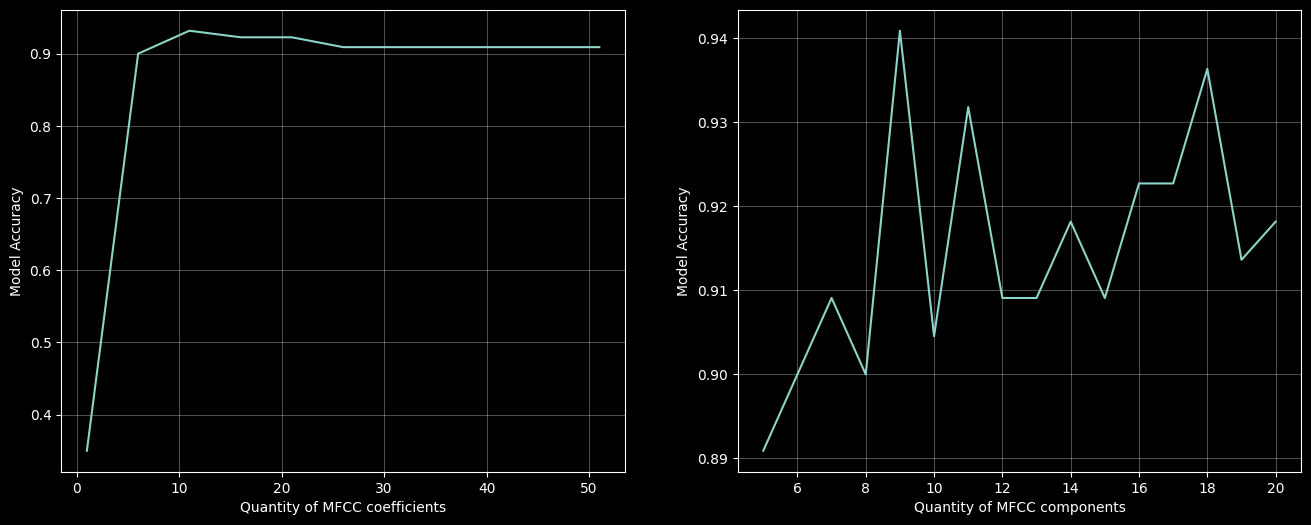

In [ ]:
fig = plt.figure(figsize = (16,6))
plt.style.use(['dark_background'])

n_mfcc_coefficients = np.arange(1,56,5)
n_mfcc_comp_results = []

for n in n_mfcc_coefficients:
  parameters_mfcc_experiment['n_mfcc'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data,parameters_mfcc_experiment)
  model_accuracy,_,_ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_mfcc_comp_results.append(model_accuracy)

plt.subplot(1,2,1)
plt.plot(n_mfcc_coefficients, n_mfcc_comp_results)
plt.xlabel('Quantity of MFCC coefficients')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

n_mfcc_coefficients = np.arange(5,21,1)
n_mfcc_comp_results = []

for n in n_mfcc_coefficients:
  parameters_mfcc_experiment['n_mfcc'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
  model_accuracy,_,_ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_mfcc_comp_results.append(model_accuracy)

plt.subplot(1,2,2)
plt.plot(n_mfcc_coefficients, n_mfcc_comp_results)
plt.xlabel('Quantity of MFCC components')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

In [ ]:
#Setting optimal n_mfcc parameter
parameters_mfcc_experiment['n_mfcc'] = 9

#Verifiation to the graph
audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
model_accuracy, _ , _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
print(f"Overall accuracy (n_mfcc stage) = {model_accuracy}")

Overall accuracy (n_mfcc stage) = 0.9409090909090907


* Wnioski:

Z testów wynika, że najwyższa dokładność modelu osiągana jest dla liczby współczynników `n_mfcc = 9`. Dalsze dodawanie ich jest bezcelowe, gdyż nie wpływa to pozytywnie na model i dostajemy accuracy

Wpływ zmiennej na skuteczność modelu jest jak najbardziej zauważalna, szczególnie w zakresie liczby współczynników. Skok skuteczności w kilku pierwszyc współczynikach jest bardzo gwałtowny.

## 2. Wpływ liczby filtrów melowych

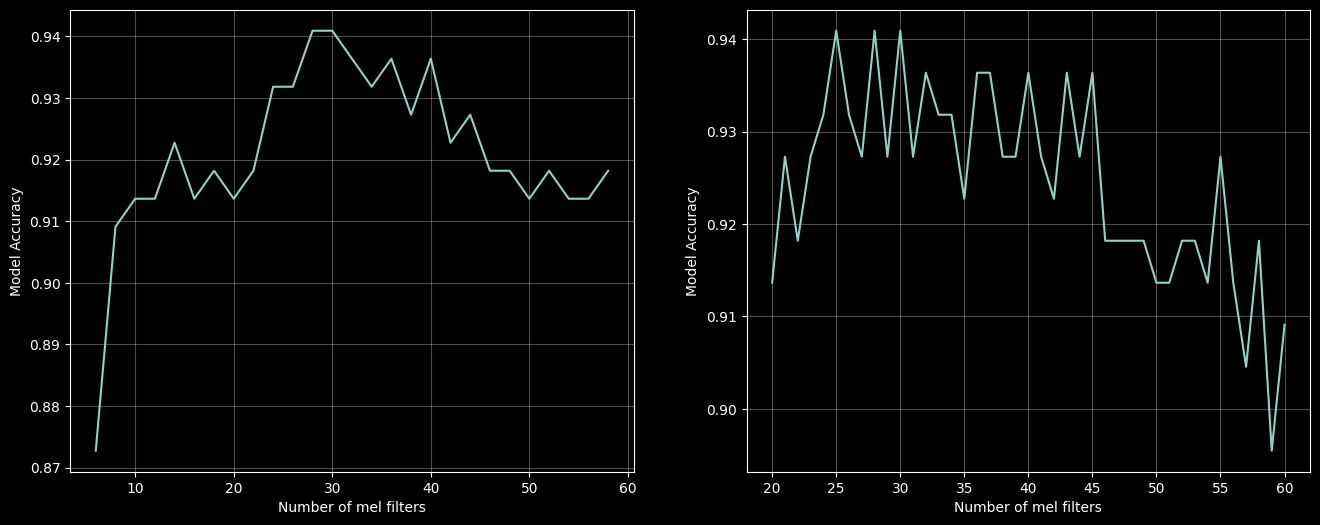

In [ ]:
fig = plt.figure(figsize = (16,6))
plt.style.use(['dark_background'])

n_mel_filters = np.arange(6,60,2)
n_mel_results = []

for n in n_mel_filters:
  parameters_mfcc_experiment['n_mels'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data,parameters_mfcc_experiment)
  model_accuracy,_,_ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_mel_results.append(model_accuracy)

plt.subplot(1,2,1)
plt.plot(n_mel_filters, n_mel_results)
plt.xlabel('Number of mel filters')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

n_mel_filters = np.arange(20,61,1)
n_mel_results = []

for n in n_mel_filters:
  parameters_mfcc_experiment['n_mels'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data,parameters_mfcc_experiment)
  model_accuracy,_,_ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_mel_results.append(model_accuracy)

plt.subplot(1,2,2)
plt.plot(n_mel_filters, n_mel_results)
plt.xlabel('Number of mel filters')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

#print(f"maximum accuracy for number of mel filters = {n_mel_filters[np.argmax(n_mel_results)]}")

In [ ]:
#Setting optimal number of mel filters
parameters_mfcc_experiment['n_mels'] = 25

#verification to the graph
audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
model_accuracy, _ , _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
print(f"Overall accuracy (n_mels stage) = {model_accuracy}")

Overall accuracy (n_mels stage) = 0.9409090909090907


* Wnioski:

Z testów wynika, że najwyższa dokładnośc modelu osiągana jest dla liczby filtrów melowych `n_mels = 25`. Należy zauważyć, że skutecznośc modelu zmienia się w sposób skokowy względem ilości zastosowanych filtrów - nie jest widoczny jednoznaczny trend.

Ponadto w trakcie eksperymentowania z wartościami zauważono, że optymalna liczba filtrów melowych zmienia się w zależności od użytej liczby komponentów mfcc.

Zmiana skuteczności modelu w standardowo używanym zakresie liczby filtró melowych (20 - 40) wynosi poniżej 3 punktów procentowych, a zakres ten maleje w przypadku analizy zakresu 25 - 40 filtrów. Nie jest to komponent o największym wpływnie na model. Można było się tego spodziewać, ponieważ...

## 3. Wpływ typu macierzy kowariancji

In [ ]:
covariance_types = ['full', 'tied', 'diag', 'spherical']

for cov in covariance_types:
  parameters_gmm_experiment['covariance_type'] = cov
  audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
  accuracy, _, _  = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  print('Accuracy of ' + str(cov) + ' covariance type GMM: ' + str(accuracy))

Accuracy of full covariance type GMM: 0.9045454545454543
Accuracy of tied covariance type GMM: 0.9
Accuracy of diag covariance type GMM: 0.9409090909090907
Accuracy of spherical covariance type GMM: 0.8181818181818182


In [ ]:
#Setting optimal number of covariance type
parameters_gmm_experiment['covariance_type'] = 'diag'

#verification to the calculations
audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
model_accuracy, _ , _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
print(f"Overall accuracy (cov_type stage) = {model_accuracy}")

Overall accuracy (cov_type stage) = 0.9409090909090907


W wyniku sprawdzenia typu macierzy kowariancji, największe accuracy modelu otrzymano dla typu `diag`, reszta typów zauważalnie pogarszała model. Z tego powodu nie zmieniano tego parametru.

Spodziewano się, że zastosowanie pełnej macierzy kowariancji da zawsze większą dokładnośc kosztem dłuższego czasu obliczania, jednak nie okazało się to mieć miejsca.


CHYBA DO WYWALENIA
W wyniku sprawdzenia typu macierzy kowariancji, większe accuracy modelu otrzymano dla typu `diag` - z tego powodu nie zmieniano tego parametru. Podczas pracy z kodem, zdażały się jednak sytuacje, że uzyskiwano dokładność o około 4% dla pełnej macierzy kowariancji. Nie udało się potwierdzić jednoznacznej przyczyny zmienności tej cechy, jednak można przypuszczać że w zalezności od użytych innych parametrów (np. ilości użytych współczynników cepstralnych) przekłada się na korelację danych, a w konsekwencji wartości uzyskiwane z pełną lub diagonalną macierzą kowariancji.




## 4. Wpływ liczby komponentów modelu GMM

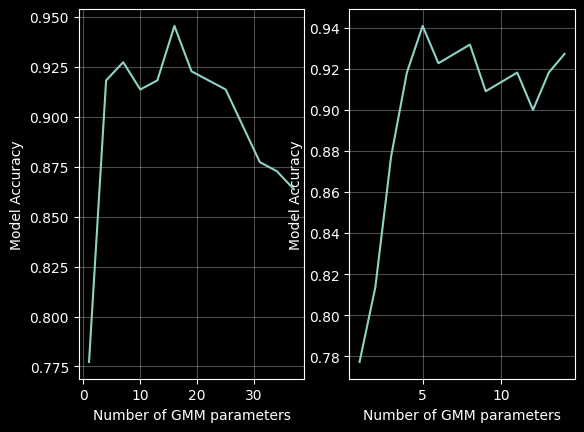

In [ ]:
n_gmm_components = np.arange(1,40,3)
n_gmm_components_results = []

for n in n_gmm_components:
  parameters_gmm_experiment['n_components'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
  model_accuracy, _, _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_gmm_components_results.append(model_accuracy)

plt.subplot(1,2,1)
plt.plot(n_gmm_components, n_gmm_components_results)
plt.xlabel('Number of GMM parameters')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

n_gmm_components = np.arange(1,15,1)
n_gmm_components_results = []

for n in n_gmm_components:
  parameters_gmm_experiment['n_components'] = n
  audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
  model_accuracy, _, _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
  n_gmm_components_results.append(model_accuracy)

plt.subplot(1,2,2)
plt.plot(n_gmm_components, n_gmm_components_results)
plt.xlabel('Number of GMM parameters')
plt.ylabel('Model Accuracy')
plt.grid(alpha=0.3)

Najbardziej optymalną liczbów komponentów GMM jest `n_components = 5`. Ponad tą ilością mamy tendencję spadkową wartości accuracy, czyli w zasadzie przetrenowanie naszego modelu.
Zasadne jest określenie, że komponenty gmm mają widoczny wpływ na skuteczność modelu. Zakres 0.80 - 0.91 jest dość duży, a dość niski próg przetrenowania modelu wskazuje na duże znaczenie tego hiperparametru.

In [ ]:
#Setting optimal number of gmm components

parameters_gmm_experiment['n_components'] = 5

#verification to the graph
audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_experiment)
model_accuracy, _ , _ = cross_validate(audio_data_mfcc, parameters_gmm_experiment, n_splits, speakers)
print(f"Overall accuracy (n_components stage) = {model_accuracy}")

Overall accuracy (n_components stage) = 0.9409090909090907


## Optymalizowane hiperparametry na podstawie powyższych testów:

In [ ]:
parameters_mfcc_optimal_found = {
    'sr' : 16000,
    'n_mfcc' : 9,
    'n_fft' : 512,
    'win_length' : 320,
    'hop_length' : 160,
    'n_mels' : 25
}

parameters_gmm_optimal_found = {
    'n_components' : 5,
    'covariance_type' : 'diag',
    'init_params' : 'kmeans',
    'random_state' : 12
}

## 5. Wpływ normalizacji CMVN

Przewidywano, że zastosowanie normalizacji znacznie poprawi skuteczność modelu. W związku z rozbieżnościami w jakości ngrań w zwłaszcza w zbiorze ewaluacyjnym, uniezależnienie danych treningowych od ich głośności powinno zauważalnie poprawić rozpoznawanie próbek ze zbioru ewaluacyjnego.

In [ ]:
def cmvn(mfcc):
    stdevs = np.std(mfcc,1)
    means = np.mean(mfcc,1)
    mfcc_normalised = ((mfcc.T - means)/stdevs).transpose()
    return mfcc_normalised


def create_cmvn_dictlist(mfcc_dictlist):

  result_dictlist = deepcopy(mfcc_dictlist)

  for i, dictlist in enumerate(result_dictlist):
    for key, mfcc in dictlist.items():
      mfcc_untransposed = mfcc.T
      mfcc_normalised = cmvn(mfcc_untransposed)
      result_dictlist[i][key] = mfcc_normalised.T
  return result_dictlist


audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_optimal_found)
audio_data_cmvn = create_cmvn_dictlist(audio_data_mfcc)

model_accuracy_cmvn, recog_rates , kfold = cross_validate(audio_data_cmvn, parameters_gmm_optimal_found, n_splits, speakers)
print(f"Accuracy for model using cmvn: {model_accuracy_cmvn}")

Accuracy for model using cmvn: 0.95


Zastosowanie normalizacji danych poprawiło skuteczność na danych treningowych modelu o niecały 1 punkt procentowy. Mimo to użycie cmvn może być ważne w przypadku klasyfikacji bardziej zróżnicowanych pod kątem głośności i zaszumienia nagrań cyfr

## 6. Wpływ delty oraz delty-delty mfcc

Przewidywano, że zastosowanie delty oraz delty-delty mfcc poprawi skutecznośc modelu, ponieważ jest to sposób na uzyskanie dodatkowych informacje o analizowanym sygnale. Pozwala więc dostarczyć większej ilości danych do treningu oraz kwalifikacji.

In [ ]:
def create_mfcc_delta_dictlist(mfcc_dictlist):

  result_dictlist = deepcopy(mfcc_dictlist)

  for i, dictlist in enumerate(result_dictlist):
    for key, mfcc in dictlist.items():
      mfcc_untransposed = mfcc.T
      delta = librosa.feature.delta(mfcc_untransposed)
      combined_matrix = np.vstack((mfcc_untransposed, delta))
      result_dictlist[i][key] = combined_matrix.T

  return result_dictlist


def create_mfcc_delta_delta_dictlist(mfcc_dictlist):

  result_dictlist = deepcopy(mfcc_dictlist)

  for i, dictlist in enumerate(result_dictlist):
    for key, mfcc in dictlist.items():
      mfcc_untransposed = mfcc.T
      delta = librosa.feature.delta(mfcc_untransposed)
      delta_delta = librosa.feature.delta(mfcc_untransposed, order=2)
      combined_matrix = np.vstack((mfcc_untransposed, delta, delta_delta))
      result_dictlist[i][key] = combined_matrix.T

  return result_dictlist


audio_data_mfcc = create_mfccs_dictlist(train_data, parameters_mfcc_optimal_found)
audio_data_cmvn = create_cmvn_dictlist(audio_data_mfcc)

model_accuracy, recog_rates , kfold = cross_validate(audio_data_cmvn, parameters_gmm_optimal_found, n_splits, speakers)

audio_data_mfcc_delta = create_mfcc_delta_dictlist(audio_data_cmvn)
model_accuracy_delta, recog_rates_delta , _ = cross_validate(audio_data_mfcc_delta, parameters_gmm_optimal_found, n_splits, speakers)

audio_data_mfcc_delta_delta = create_mfcc_delta_delta_dictlist(audio_data_cmvn)
model_accuracy_delta_delta, recog_rates_delta_delta , _ = cross_validate(audio_data_mfcc_delta_delta, parameters_gmm_optimal_found, n_splits, speakers)


print(f"Accuracy for model without delta: {model_accuracy}")
print(f"Accuracy for model with delta: {model_accuracy_delta}")
print(f"Accuracy for model with delta and delta_delta: {model_accuracy_delta_delta}")

Accuracy for model without delta: 0.95
Accuracy for model with delta: 0.9863636363636363
Accuracy for model with delta and delta_delta: 0.9818181818181819


W ramach zbioru treningowego, skuteczność modelu poprawiła się  o 3,64 punkta procentowego co jest stosunkowo dużą wartością.

# Wytrenowanie optymalnego modelu

In [ ]:
params_gmm_optimal = {
    'n_components' : 12, #tested value
    'covariance_type' : 'diag', #tested value
    'init_params' : 'kmeans',
    'random_state' : 12
}

params_mfcc_optimal = {
    'sr' : 16000,
    'n_mfcc' : 9, #tested and changed value
    'n_fft' : 512,
    'win_length' : 320,
    'hop_length' : 160,
    'n_mels' : 25 #tested and changed value
}

audio_data_mfcc = create_mfccs_dictlist(train_data, params_mfcc_optimal)
audio_data_cmvn = create_cmvn_dictlist(audio_data_mfcc)
audio_data_cmvn_delta = create_mfcc_delta_dictlist(audio_data_cmvn)
training_mfccs = create_concatenated_mfccs(audio_data_cmvn_delta)

optimal_model = train_gmms(training_mfccs, params_gmm_optimal) #optimal trained model

model_accuracy, recog_rates, kfold = cross_validate(audio_data_cmvn_delta, params_gmm_optimal, n_splits, speakers)


print('\n     cross-validation results:')
for i, (train_idx, test_idx) in enumerate(kfold.split(speakers)):
  print(f"Fold {i}:")
  print(f"  Test:  index={test_idx}")
  print(f"  Accuracy: {recog_rates[i]}")
print(f"Overall accuracy = {model_accuracy}")

print(f"Difference between initial and tuned model: {0.9863636363636363 - 0.9272727272727274}")



     cross-validation results:
Fold 0:
  Test:  index=[0 1]
  Accuracy: 1.0
Fold 1:
  Test:  index=[2 3]
  Accuracy: 0.9
Fold 2:
  Test:  index=[4 5]
  Accuracy: 0.95
Fold 3:
  Test:  index=[6 7]
  Accuracy: 1.0
Fold 4:
  Test:  index=[8 9]
  Accuracy: 1.0
Fold 5:
  Test:  index=[10 11]
  Accuracy: 1.0
Fold 6:
  Test:  index=[12 13]
  Accuracy: 1.0
Fold 7:
  Test:  index=[14 15]
  Accuracy: 1.0
Fold 8:
  Test:  index=[16 17]
  Accuracy: 1.0
Fold 9:
  Test:  index=[18 19]
  Accuracy: 1.0
Fold 10:
  Test:  index=[20 21]
  Accuracy: 1.0
Overall accuracy = 0.9863636363636363
Difference between initial and tuned model: 0.05909090909090897


* Wnioski:

Zastosowanie poprawionych hiperparametrów parametrów oraz odpowiedniego preprocessingu danych wejściowych pozwoliło na stworzenie modelu większej skuteczności `(5,9 ptk % względem poprzedniego modelu)`. Należy zauważyć, że optymalne hiperparametry należy dobierać do konkretnego modelu, ponieważ zmiana jednego z nich wpływa na porządaną wielkość pozostałych.

* Podsumowanie:
 - > kluczowy wpływ na działanie modelu ma zastosowanie odpowiedniej ilości `komponentów gmm`. W przypadku zbyt małej wartości, skuteczność modelu jest niewielka, natomiast zbyt duża wartość powoduje przetrenowanie modelu a zarazem ponownie znaczny spadek jego skuteczności.
 - odpowiedny `typ macierzy kowariancji` wydaje się mieć istotny wpływ na funkcjonowanie modelu.
 - użycie `delt mfcc` również w zauważalny sposób wpływa na skuteczność modelu dostarczając większej ilości informacji o sygnale.
 - chociaż znormalizowanie macierzy mfcc nie daje szczególnie dużego wzrostu wyników na zbiorze treningowym, parametr został uznany za ważny w przypadku rozpoznawania sygnałów z poza zbioru treningowego, które mogą odbiegać jakością i jednorodonością od zawartych w nim nagrań.   (zobaczyć na ewaluacyjnym I guess)
 - zastosowanie wystarczającej liczby `komponentów mfcc` ma duże znaczenie, jednak najważniejsze jest aby nie zejść poniżej wartości 8.
 Znalezienie optymalnej ilości może usprawnić model, jednak stosowanie standardowych 12 komponentów lub większej ilości nie powinno znacznie pogorszyć funkcjonowania modelu (zobaczyć jak się spradzi z ewaluacyjnym !!!)
 - `liczba filtrów melowych` nie ma dużego wpływu na skuteczność modelu. Operując w typowym zakresie 20-40 filtrów, nie uzyskamy znacznych zmian w działaniu modelu.

# Ewaluacja

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/colab/tm2023/Grupa_4/Projekt_Klasyfikator_Liczb/')
from eval import load_keys, evaluate, load_results, load_keys_ia
def evaluation(dataset, gmm_model):
  if dataset == 'eval':
    original_digits=load_keys()
    csv_name = 'results.csv'
  elif dataset == 'eval_ia':
    original_digits=load_keys_ia()
    csv_name = 'results_ia.csv'
  else:
    print("Wrong dataset")
    return

  folder_path = dataset + '/' + dataset
  file_names = [f for f in os.listdir(folder_path) if f.endswith('.wav')] #names of all the .wav files in the folder
  file_names.sort()

  evaluate_data = [{} for _ in range(10)]
  for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)  #creates paths to files
    audio_data, _ = librosa.load(file_path, sr=None)
    digit = original_digits[file_name]
    evaluate_data[digit].update({file_name : audio_data})

  evaluate_mfcc = create_mfccs_dictlist(evaluate_data, params_mfcc_optimal)
  evaluate_cmvn = create_cmvn_dictlist(evaluate_mfcc)
  evaluate_cmvn_delta = create_mfcc_delta_dictlist(evaluate_cmvn)

  acc,dig_acc = test_model(evaluate_cmvn_delta, gmm_model)

  classified_data = {}

  for dictlist in evaluate_cmvn_delta:
    for key, mfcc in dictlist.items():
      classified_digit, loglike_value, _ = classify(mfcc, gmm_model)
      classified_data[key] = (classified_digit, loglike_value)
  import csv
  with open(csv_name, 'w') as file:
      writer = csv.writer(file)

      for key in classified_data:
          writer.writerow([key, ] + [i for i in classified_data[key]])
  return evaluate(csv_name)


Classification accuracy based on 'results.csv': 94.00%


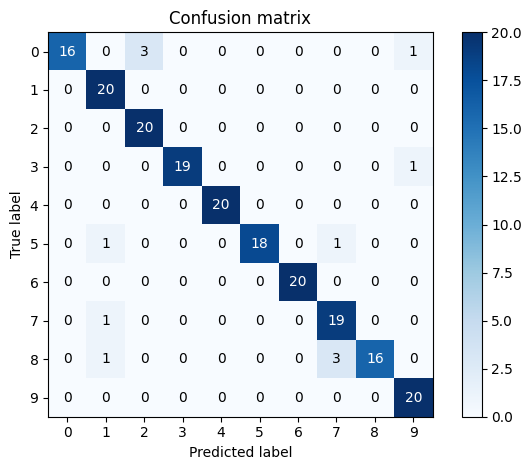

Classification accuracy based on 'results_ia.csv': 78.45%


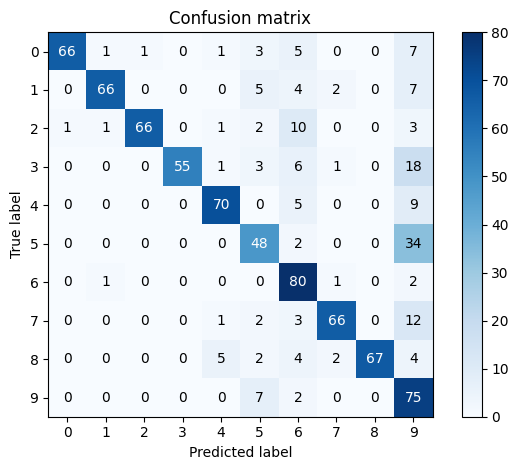

In [ ]:
evaluation('eval', optimal_model)
evaluation('eval_ia', optimal_model)

Skuteczność klsyfikatora dla pozostałych ze zbioru, z którego został utworzony zbiór treningowy wyniosła 94%. Jest to bardzo dobry wynik i oznacza, że klasyfikator ma odpowiednio dobrane hiperparametry.


Skuteczność klasyfikatora dla nagrań studentów inżynierii akustycznej wyniosła 78,5%. Jest to wynik zadowalający. Nagrania różnią się od tych, na których trenowano model, przez co łatwiej o wystąpienie pomyłek w klasyfikacji. Największy problem pojawiał się przy rozpoznawaniu cyfry 5 - klasyfikowano ją jaką cyfrę 9. Cyfry te brzmią dość podobnie i jeśli na nagraniu przez studentów nie były wypowiedziane wyraźnie, mogły spowodować późniejszy błąd klasyfikacji.